In [252]:
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from math import log
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.stats import entropy

import seaborn as sns

In [253]:
k = 10
genes = np.zeros(k)

In [254]:
sns.set()

In [255]:
entropy(seriesb)

-inf

In [11]:
gamma = 0.0138172
rho = 0.2

eta = 6.205e-6
phi = 6.205e-6
xi = 6.205e-6

k1=10e-12
k2=10e-3
r_r = 1e-1
l_r = 5000
l_p = 975


def dN_dt(X, t=0,
        gamma = 0.0138172,
        rho = 0.2,
        eta = 6.205e-6,
        phi = 6.205e-6,
        xi = 6.205e-6,
        k1 = 10e-12,
        k2=10e-3,
        r_r = 1e-1,
        l_r = 5000,
        l_p = 975):
    
    M = X[0] #X[0] = [mRNA](t)
    AA = X[1] #X[1] = [aminoacids](t)
    R = X[2] #X[2] = [ribosomes](t)
    P = X[3] #X[3] = [proteins](t)
    ATP = X[4] #X[4] = [ATP](t)
    ADP = X[5] #X[5] = [ADP](t)
 
    dM_dt = rho*P - xi*M
    dR_dt = gamma*AA*R*k1*r_r/l_r - eta*R
    dP_dt = (1-gamma)*AA*R*k2*r_r/(l_p) - phi*P
    dAA_dt = -1*l_p*dP_dt - l_r*dR_dt
    dATP_dt = -dAA_dt*4
    dADP_dt =  -dATP_dt
    
    
    return np.array([
        dM_dt,
        dAA_dt,
        dR_dt,
        dP_dt,
        dATP_dt,
        dADP_dt
        
    ])

def cell_generation(initial_array=np.array([10e10,10e18,5773,2.11e6,10e18,0]).reshape(1,-1),
                    gamma = 0.0138172,
                    rho = 0.2,
                    eta = 6.205e-6,
                    phi = 6.205e-6,
                    xi = 6.205e-6,
                    k1=10e-12,
                    k2=10e-3,
                    r_r = 1e-1,
                    l_r = 5000,
                    l_p = 975,
                    timesteps=2000):

    initial_mrna = initial_array[-1,0]/2
    initial_aa = initial_array[-1,1]/2
    initial_ribosomes = initial_array[-1,2]/2
    initial_proteins = initial_array[-1,3]/2
    initial_atp = initial_array[-1,4]/2
    initial_adp = initial_array[-1,5]/2
    
    t = np.arange(timesteps)
    
    return np.row_stack([initial_array,
                            odeint(partial(dN_dt,gamma = gamma,
                                        rho = rho,
                                        eta = eta,
                                        phi = phi,
                                        xi = xi,
                                        k1= k1,
                                        k2= k2,
                                        r_r = r_r,
                                        l_r = l_r,
                                        l_p = l_p), 
                                           [initial_mrna, 
                                           initial_aa,
                                           initial_ribosomes,
                                           initial_proteins,
                                           initial_atp,
                                           initial_adp], t)])

def sim_cell_dynamics(n_generations, t_per_generation,
                    initial_array = np.array([10e10,10e18,5773,2.11e6,10e18,0]).reshape(1,-1),  
                    gamma = 0.0138172,
                    rho = 0.2,
                    eta = 6.205e-6,
                    phi = 6.205e-6,
                    xi = 6.205e-6,
                    k1=1,
                    k2=1,
                    r_r = 1e-1,
                    l_r = 5000,
                    l_p = 975):
    
    #global gamma, rho, eta, phi, xi, k1, k2, r_r, l_r, l_p
    
    cell = cell_generation(timesteps=t_per_generation, initial_array = initial_array, gamma=gamma, rho=rho, eta=eta, 
                           phi=phi, xi=xi, k1=k1, k2=k2, r_r=r_r, l_r=l_r, l_p=l_p)
    
    for i in range(n_generations-1):
        cell = cell_generation(cell, timesteps=t_per_generation, initial_array = initial_array, gamma=gamma, rho=rho, eta=eta, 
                           phi=phi, xi=xi, k1=k1, k2=k2, r_r=r_r, l_r=l_r, l_p=l_p)
        
    return cell

In [194]:
d = 20

prot_array = np.zeros((d,d))
ribo_array = np.zeros((d,d))
aa_array = np.zeros((d,d))


for i,initial_aa in enumerate(np.logspace(10,18,d)):
    for j,gamma_0 in enumerate(np.linspace(0.01,0.9,d)):
        cell_ij = sim_cell_dynamics(n_generations=1,t_per_generation=500, gamma=gamma_0, k1=1e-10, k2=1e-10, \
                          rho=0, initial_array=np.array([10e10,initial_aa,5773,2.11e6,10e18,0]).reshape(1,-1))        
        
        #print('Gamma = {}, [AA]0= {}.'.format(gamma_0, initial_aa))
        #print(cell_ij[-1,2])
        prot_array[i,j] = cell_ij[-1,3]
        ribo_array[i,j] = cell_ij[-1,2]
        
        aa_array[i,j] = cell_ij[-1,1]
    

In [195]:
sim_cell_dynamics(n_generations=1,t_per_generation=500, gamma=0.01, \
                          initial_array=np.array([10e10,10e22,5773,2.11e6,10e18,0]).reshape(1,-1))[-1,2]      
#ribo_array

101012978.57917997

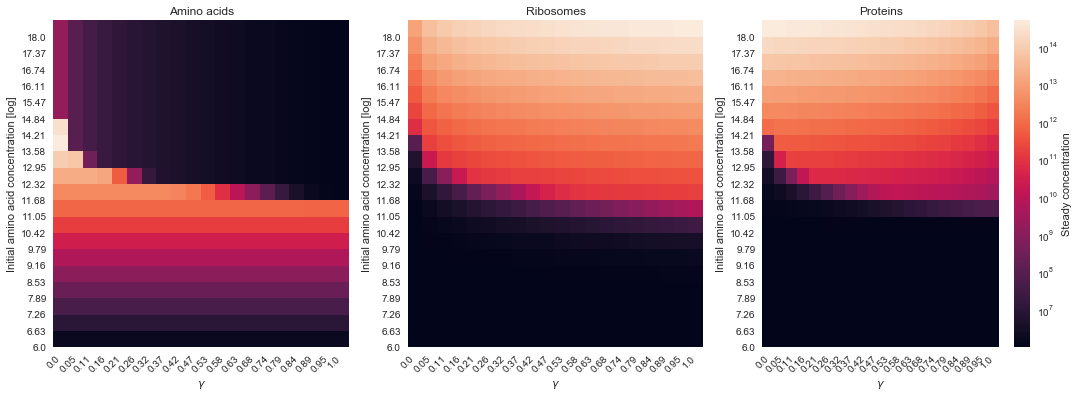

In [196]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
hm_prot = axes[2].pcolor(prot_array, norm=LogNorm(vmin=np.min(prot_array)))
hm_ribo = axes[1].pcolor(ribo_array, norm=LogNorm(vmin=np.min(ribo_array)))
hm_aa   = axes[0].pcolor(aa_array, norm=LogNorm(vmin=np.min(aa_array)))


for ax in axes:
    ax.set_xticks(range(d))
    ax.set_yticks(range(d))
    ax.set_xticklabels(np.round(np.linspace(0,1,d),2), rotation=45)
    ax.set_yticklabels(np.round(np.linspace(6,18,d),2))
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'Initial amino acid concentration [log]')


axes[0].set_title('Amino acids')
axes[1].set_title('Ribosomes')
axes[2].set_title('Proteins')


#plt.ylim([0.01,0.1])
#plt.xlim([6,18])



#cb2 = plt.colorbar(hm_prot,norm=LogNorm(vmin=np.min(prot_array), vmax=np.max(prot_array)))
cb1 = plt.colorbar(hm_prot,norm=LogNorm(vmin=np.min(prot_array), vmax=np.max(prot_array)))
#cb0 = plt.colorbar(hm_prot,norm=LogNorm(vmin=np.min(prot_array), vmax=np.max(prot_array)))
cb1.set_label('Steady concentration')
plt.show()

In [197]:
#ribo_array

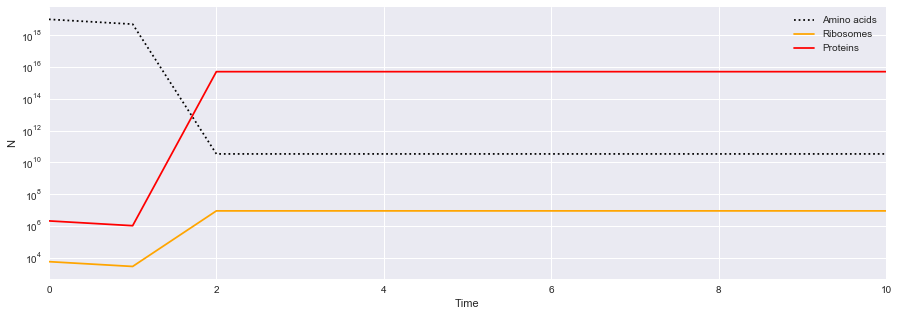

In [193]:
fig, axes = plt.subplots(1, figsize=(15,5))

cell = sim_cell_dynamics(1,500, np.array([10e10,10e18,5773,2.11e6,10e18,0]).reshape(1,-1), gamma=0.9)
mrnas = cell[:,0]
aas = cell[:,1]
ribo = cell[:,2]
prot = cell[:,3]
atps = cell[:,4]
adps = cell[:,5]

#axes.plot(mrnas, label='mRNA')
axes.plot(aas, label='Amino acids', c='black', linestyle='dotted')
axes.plot(ribo, label='Ribosomes', c='orange')
axes.plot(prot, label='Proteins', c='red')
#axes.plot(atps, label='ATP', c='grey')
#axes.plot(adps, label='ADP', c='violet', linestyle='dashed')

#plt.xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Time')
axes.set_ylabel('N')
axes.set_xlim([0,10])
#axes.set_ylim([0,10e20])
axes.legend(loc=1)
plt.show()

In [16]:
sim_cell_dynamics(n_generations=1,t_per_generation=500, gamma=0.9, \
                          initial_array=np.array([10e10,10e18,5773,2.11e6,10e18,0]).reshape(1,-1))[-1,2]

9002877.43334235

In [17]:
sim_cell_dynamics(n_generations=1,t_per_generation=500, gamma=0.1, \
                          initial_array=np.array([10e10,10e8,5773,2.11e6,10e18,0]).reshape(1,-1))

array([[ 1.00000000e+11,  1.00000000e+09,  5.77300000e+03,
         2.11000000e+06,  1.00000000e+19,  0.00000000e+00],
       [ 5.00000000e+10,  5.00000000e+08,  2.88650000e+03,
         1.05500000e+06,  5.00000000e+18,  0.00000000e+00],
       [ 4.99999668e+10,  3.72201991e+07,  2.88648210e+03,
         1.52964604e+06,  5.00000000e+18, -1.85111920e+09],
       ...,
       [ 5.00016071e+10,  3.69697951e+03,  2.87761217e+03,
         1.56786230e+06,  5.00000000e+18, -1.99998521e+09],
       [ 5.00016104e+10,  3.69700245e+03,  2.87759431e+03,
         1.56786239e+06,  5.00000000e+18, -1.99998521e+09],
       [ 5.00016137e+10,  3.69702539e+03,  2.87757646e+03,
         1.56786248e+06,  5.00000000e+18, -1.99998521e+09]])

In [18]:
partial(dN_dt,gamma = 0.0138172,
                                        rho = 0.2,
                                        eta = 6.205e-6,
                                        phi = 6.205e-6,
                                        xi = 6.205e-6,
                                        k1=10e-12,
                                        k2=10e-3,
                                        r_r = 1e-1,
                                        l_r = 5000,
                                        l_p = 975)

functools.partial(<function dN_dt at 0x10ba06f28>, gamma=0.0138172, rho=0.2, eta=6.205e-06, phi=6.205e-06, xi=6.205e-06, k1=1e-11, k2=0.01, r_r=0.1, l_r=5000, l_p=975)

In [19]:
initial_array=np.array([10e10,10e18,5773,2.11e6,10e18,0]).reshape(1,-1)
initial_mrna = initial_array[-1,0]/2
initial_aa = initial_array[-1,1]/2
initial_ribosomes = initial_array[-1,2]/2
initial_proteins = initial_array[-1,3]/2
initial_atp = initial_array[-1,4]/2
initial_adp = initial_array[-1,5]/2

odeint(partial(dN_dt,gamma = 0.0138172,
                                        rho = 0.2,
                                        eta = 6.205e-6,
                                        phi = 6.205e-6,
                                        xi = 6.205e-6,
                                        k1=10e-12,
                                        k2=10e-3,
                                        r_r = 1e-1,
                                        l_r = 5000,
                                        l_p = 975), 
                                           [initial_mrna, 
                                           initial_aa,
                                           initial_ribosomes,
                                           initial_proteins,
                                           initial_atp,
                                           initial_adp],t=0)

array([[5.0000e+10, 5.0000e+18, 2.8865e+03, 1.0550e+06, 5.0000e+18,
        0.0000e+00]])

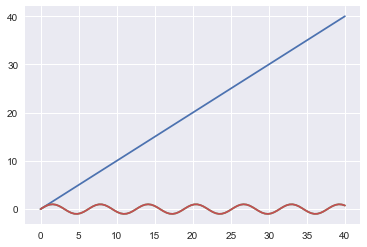

In [161]:
def dX_dt(X, t=0, a=0.5, b=0.2, c=0.5, d=0.8):
#     a = 0.5
#     b = 0.2
#     c = 0.5
#     d = 0.8
    
    return np.array([
        1, #dt/dt = dX[0]/dt 1
        np.cos(X[0]), #dX/dt = dX[1]/d
        np.cos(X[0])
    ])

plt.plot(np.linspace(0,40,100),odeint(dX_dt, [0,0,0], t=np.linspace(0,40,100)))

In [231]:
timeseries = odeint(dX_dt, [0,0,0], t=np.linspace(0,1e3,100))

seriesa = timeseries[:,1]
seriesb = timeseries[:,2]

In [232]:
seriesa

array([ 0.        , -0.62585846,  0.97626045, -0.89698247,  0.4229193 ,
        0.23728332, -0.79305007,  0.9997748 , -0.76647062,  0.19582272,
        0.46101301, -0.91494334,  0.96618325, -0.59217848, -0.04245878,
        0.65841056, -0.98457604,  0.8774044 , -0.38406197, -0.27831539,
        0.81819966, -0.99797109,  0.73850912, -0.15400831, -0.49827475,
        0.93125474, -0.95436271,  0.55743136,  0.08484241, -0.68977304,
        0.99111753, -0.85624252,  0.34451356,  0.31884655, -0.84187252,
        0.99436868, -0.70921463,  0.1119176 ,  0.53463915, -0.94588487,
        0.9408227 , -0.52167702, -0.12707089,  0.71989363, -0.99586926,
        0.8335382 , -0.30434174, -0.35880124,  0.86402854, -0.98897096,
        0.6786426 , -0.06962311, -0.57003742,  0.95881102, -0.92558365,
        0.48498387,  0.1690724 , -0.74871363,  0.99882729, -0.80932827,
        0.26362328,  0.3981106 , -0.88462424,  0.98179157, -0.64684484,
        0.02720497,  0.6044095 , -0.97000585,  0.90867735, -0.44

In [249]:
n=10000
histoa, binsa = np.histogram(seriesa, normed=True, bins=n)
histob, binsb = np.histogram(seriesb, normed=True, bins=n)
histoab, binsmarga, binsmargb = np.histogram2d(seriesa,seriesb, normed=True, bins=n)
# integrala = 0
# for i in range(len(histoa)):
#     integrala = integrala + (binsa[i+1]-binsa[i])*histoa[i]
# print(integrala)

In [250]:
mutualinfo = 0

for i in range(len(histoa)):
    px = (binsa[i+1]-binsa[i])*histoa[i]
    for j in range(len(histob)):
        py = (binsb[j+1]-binsb[j])*histob[j]
        
        pxy = (binsa[i+1]-binsa[i])*(binsb[j+1]-binsb[j])* \
            histoab[i,j]

            mutualinfo += pxy * log(pxy/px/py,2)
        
        

In [251]:
mutualinfo

6.643856189774715

In [ ]:
for x in seriesa:
    for y in seriesb:
        

In [326]:
def dN_dt(X, t=0,
        gamma = 0.0138172,
        rho = 0.2,
        eta = 6.205e-6,
        phi = 6.205e-6,
        xi = 6.205e-6,
        k1=10e-12,
        k2=10e-3,
        r_r = 1e-1,
        l_r = 5000,
        l_p = 975):
    
    M = X[0] #X[0] = [mRNA](t)
    AA = X[1] #X[1] = [aminoacids](t)
    R = X[2] #X[2] = [ribosomes](t)
    P = X[3] #X[3] = [proteins](t)
    ATP = X[4] #X[4] = [ATP](t)
    ADP = X[5] #X[5] = [ADP](t)

    dM_dt = rho*P - xi*M
    dR_dt = gamma*AA*R*k1*r_r/l_r - eta*R
    dP_dt = (1-gamma)*AA*R*k2*r_r/(l_p) - phi*P
    dAA_dt = -1*l_p*dP_dt - l_r*dR_dt
    dATP_dt = -dAA_dt*4
    dADP_dt =  -dATP_dt
    
    
    return np.array([
        dM_dt,
        dAA_dt,
        dR_dt,
        dP_dt,
        dATP_dt,
        dADP_dt
        
    ])

#odeint(partial(dN_dt, gamma=0.2), [10e10,10e18,5773,2.11e6,10e18,0], np.linspace(0,50))[-1,:]